<a href="https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/2_%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%83%86%E3%83%83%E3%83%89%E3%82%A2%E3%83%8B%E3%83%BC%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## シミュレーテッドアニーリング

ここでは、量子アニーリングの元となった、シミュレーテッドアニーリングというアルゴリズムを紹介します。少し前回と被るところもありますが、本章ではコードを少し動かしてみながらアルゴリズムを理解してみましょう。

シミュレーテッドアニーリングは最適化問題を近似的に解く汎用的なアルゴリズムです。アルゴリズムの中身に入る前に対象である最適化問題について紹介します。

### 最適化問題
最適化問題とは、あるd個の変数 $x \in \mathcal R^d$ を引数に持つコスト関数 $f(x)$ を最小化する変数 $x$ を求める問題です。例えばものすごく簡単な例を考えるとすると、コスト関数が
$$f_{cost}(x, y) = x^2 + y^2, ~~ x,y \in \mathcal R$$
のときコストを最小化する変数$x, y$を求めよ。という問題になります。この解答は$x=0.0, y=0.0$ です。さらに一般には制約条件という条件が課されます。例えば以下のような条件です。
$$x > 1.0$$
$$x + y = 1.0$$
のような変数に対しての不等式もしくは等式制約が課されることが多いです。

### 組合せ最適化問題

量子アニーリング、シミュレーテッドアニーリングでよく扱われる組合せ最適化問題についてここで説明しておきます。
組合せ最適化問題は上記で説明した最適化問題の変数が離散的な値を取る問題です [wikipedia](https://ja.wikipedia.org/wiki/%E7%B5%84%E5%90%88%E3%81%9B%E6%9C%80%E9%81%A9%E5%8C%96)。  
量子アニーリングではよく変数の取りうる値が2値(0 or 1)の場合が考えられます。  
組合せ最適化問題でよく扱われる巡回セールスマン問題について2値変数で定式化してみましょう。

- 巡回セールスマン問題 [wikipedia](https://ja.wikipedia.org/wiki/%E5%B7%A1%E5%9B%9E%E3%82%BB%E3%83%BC%E3%83%AB%E3%82%B9%E3%83%9E%E3%83%B3%E5%95%8F%E9%A1%8C)  
  都市の集合と各2都市間の移動コスト（たとえば距離）が与えられたとき、全ての都市をちょうど一度ずつ巡り出発地に戻る巡回路のうちで総移動コストが最小のものを求める（セールスマンが所定の複数の都市を1回だけ巡回する場合の最短経路を求める）組合せ最適化問題である。
  
まず与えられるのは、都市の集合 $V$ と 各都市間の移動コスト$d_{ij}:  i,j \in V$が与えられます。  
変数は経路だが、2値変数を用いて経路を表すことを考えます。2値変数$x_{it}$を以下のように定義しましょう。
$$x_{it} : \text{都市}iをt番目に回るときに1 そうでないときに 0$$
という変数を用いると経路を表現することができます。例えば$x_{10}=1, x_{21}=1, x_{42}=1$ で他が0の時は$1 \rightarrow 2 \rightarrow 4$ という経路を表します。  
このときコスト関数は
$$f_{cost} = \sum_t \sum_{i,j} d_{ij} x_{i,t}x_{j,t+1}$$
と表すことができます。このコストは都市$i$を$t$番目に訪問した後に都市$j$を訪問する場合($x_{i,t}=x_{j,t+1}=1$)は総コストに移動コスト$d_{ij}$を加算する仕組みになっています。  
さらに変数に以下の制約がつきます。
$$\sum_t x_{it} = 1: \forall i ~\text{各都市は1度だけ訪れる}$$
$$\sum_i x_{it} = 1: \forall t~ \text{各時刻では1つの都市しか訪れない}$$
つまり以上の制約下でコスト$f_{cost}$を最小化する変数$x_{it}$の値を求めよ。という問題になります。 
解く方法が様々考案されており、[wikipedia](https://ja.wikipedia.org/wiki/%E5%B7%A1%E5%9B%9E%E3%82%BB%E3%83%BC%E3%83%AB%E3%82%B9%E3%83%9E%E3%83%B3%E5%95%8F%E9%A1%8C) も参考になるのでみると良いと思いますので参考にしてください。最近はこのような数理最適化に関することもQiitaに有用な記事が多いので参考になると思います。

## シミュレーテッドアニーリング(焼きなまし法)

上記のような組合せ最適化問題は一般には問題の大きさ(変数の数)が大きいと最適化解を見つけることは非常に難しく、限定的な状況で使えるアルゴリズムや近似手法を用いて解かれることが多いです。ここで紹介するのは量子アニーリングの元となったシミュレーテッドアニーリング(Simulated annealing, SA)という手法を紹介します。  
説明のために考える問題を組合せ最適化ではなく、連続変数の最適化問題を考えましょう。



変数$x$の関数として以下のようなコスト関数を考えます。

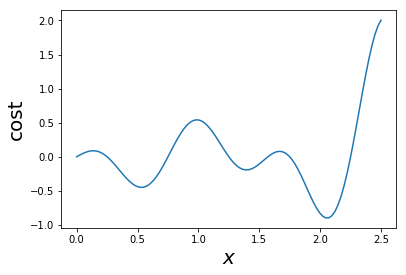

In [0]:
import matplotlib.pyplot as plt
import numpy as np

a,b,c = 1,2,3
cost = np.vectorize(lambda x : np.cos(2*np.pi*x)*np.cos(x)*x if 0.0 <= x <= 2.5 else 100)
x = np.linspace(0, 2.5, 100)
def plot_cost(cost, x):
  plt.plot(x, cost(x))
  plt.xlabel('$x$', fontsize=20)
  plt.ylabel('cost',fontsize=20)
plot_cost(cost, x)
plt.show()

上図のコスト関数は$x\simeq 2$付近に最小値があります。なので、この場合は$x\simeq 2$が解となります。
しかし、一般に実際の最適化問題ではコスト関数の形は上のグラフのように全体を知ることはできません（変数の全てのパターンを計算しなければ形を知ることはできない)。なのでどこか適当な変数の位置から周辺の情報だけでどこがコストが最小の場所なのかを探す必要があります。

例えば現在の位置$x_t$から少し位置をずらして$\pm dx$コストが下がる方向に変数$x$を更新$x_{t+1}=x_t\pm dx$して最適解を探していくことを考えましょう。





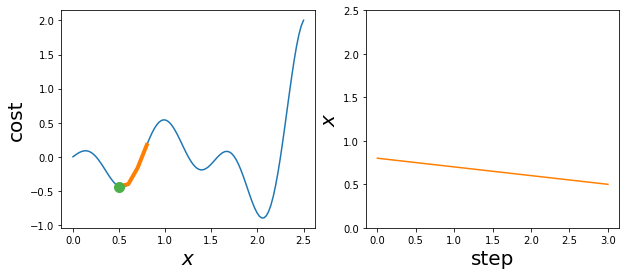

In [0]:
xt = 0.9    # 初期値
dx=0.1     # 更新幅
tau = 20   # 最大更新回数
x_history, cost_history = [], []
for _ in range(tau):
  current_cost = cost(xt)
  if cost(xt + dx) < current_cost:
    xt = xt + dx
  elif cost(xt - dx) < current_cost:
    xt = xt -dx
  else:
    break  # どの方向に更新してもコストが下がらない場合はそこで更新終了
  x_history.append(xt)
  cost_history.append(cost(xt))

def  plot_cost_history(cost, x, x_history):
  fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
  axL.plot(x, cost(x))
  axL.plot(x_history, cost(np.array(x_history)), lw=4, color='#ff7f00')
  axL.plot([x_history[-1]], [cost_history[-1]], '.', markersize=20, color='#4daf4a')
  axL.set_xlabel('$x$', fontsize=20)
  axL.set_ylabel('cost',fontsize=20)
  
  axR.plot(x_history, color='#ff7f00')
  axR.set_xlabel('step', fontsize=20)
  axR.set_ylabel('$x$', fontsize=20)
  axR.set_ylim([x[0], x[-1]])


plot_cost_history(cost, x, x_history)

plt.show()

上の図のオレンジの線はコストが下がるところを探しながら最小解を探してるときの$x$の履歴を表しています。緑の点が最終的な$x, cost$の値を示します。図からも明らかなように、コストが下がる方向だけをみていると、最小値ではなく、極小値に捕まってしまい、$x$の初期値によっては最小値を抜け出すことができないことがあります。

ここで$x\simeq 1$付近から始めても$x \simeq 2 $付近の最小解にたどり着くためには途中にあるコストの山を乗り越えなければなりません。  
そこで以下で紹介するシミュレーテッドアニーリングでは、ある確率でコストが上がる方向にも更新を許すことで、確率的に山を超えることを期待して最小値を目指します。
では実際にどのような更新を行うのかを見ていきましょう。



## シミュレーテッドアニーリング

シミュレーテッドアニーリングでは以下のように更新する。

$df := f_{cost}(x_t) - f_{cost}(x_t\pm dx)$
として
1. $df<0 \Rightarrow x_{t+1}=x_t \pm dx$に更新
2. $df > 0 \Rightarrow 確率 p(df;T) でx_{t+1}=x_t \pm dx$に更新
3. $T \rightarrow 0$へと更新しながら 1. 2. を繰り返す

ここで$\pm dx$ の符号はランダムに選ぶ。  
といった流れだ。つまり確率的にコストが上がる方向の更新も許諾する。  
ここで確率の中に新たに$T$という変数が出てきた。これはどれくらいコストが上がる方向へ許諾するかを制御するパラメータである。  
$T$が大きいとコストが上がる方向への更新を許諾しやすく($p(df, T)$が大きく)、$T$が小さいとコストが上がる方向への更新は許諾しずらく($p(df, T)$が小さい)するようなパラメータである。具体的な確率の式をみてみよう。シミュレーテッドアニーリングでよく用いられる確率は以下である。

$$p(df; T) = \exp \left(-\frac{1}{T} df\right)$$

$df$が小さければ小さいほど更新が許諾される確率が大きく、$df$が大きい場合は指数的に許諾される確率が小さくなっていることがわかる。また$T$が大きい場合は指数の肩が$0$に近くなるため$df$が大きくても確率は大きく、$T$が小さい場合は確率が小さくなることがわかる。

このパラメータ$T$を最初は大きくとって更新することで、コストが上がる方向も許し、コストの山を越え、広い解空間(変数の領域)を調べ、最後の方でパラメータ$T$を小さくすることでコストが上がる方向は許さず、下がる方向だけに更新させて、コストがより低い最小解を得るというアルゴリズムである。

このシミュレーテッドアニーリングで用いられる確率を制御するパラメータ$T$は物理の温度と対応しているため、$T$を温度と呼ぶ。温度が高いと変数(物理でいう状態)は高温でランダムに動くが、温度が小さいと固まって行き、よりコストが小さい(物理でいうとエネルギーが小さい)ところに落ち着いていくというイメージである。

実際にどうなるかをみてみよう。

まず高温の場合どのように変数が更新されるかをみてみる。

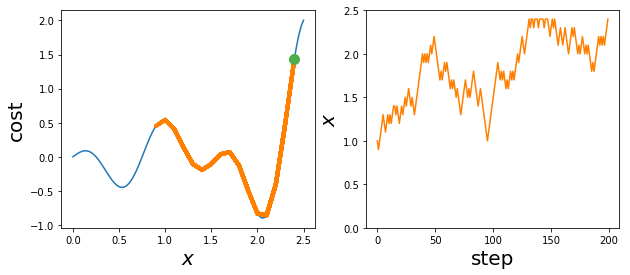

In [0]:
xt = 0.9    # 初期値
dx = 0.1   # 更新幅
tau = 200   # 最大更新回数
x_history, cost_history = [], []


def sa_update(T, cost, xt):
  sign = np.random.choice([1, -1])
  df = cost(xt + sign * dx) - cost(xt)
  if df < 0:
    return xt + sign * dx
  elif np.random.uniform(0,1) < np.exp(-1/T*df):
    return xt + sign * dx
  return xt

T = 10.0
for _ in range(tau):
  xt = sa_update(T, cost, xt)
  x_history.append(xt)
  cost_history.append(cost(xt))


plot_cost_history(cost, x, x_history)
plt.show()

高温の場合は、先ほどのコスト(エネルギー)が下がる方向のみをみるのではなく、広い空間を探索していることがわかる。

しかし高温のため、コストが低いところにたどり着いているわけではない。

次は更新のたびに温度を徐々に下げていってみよう。この温度を下げていく過程がアニーリング(焼きなまし)と言われる過程である。

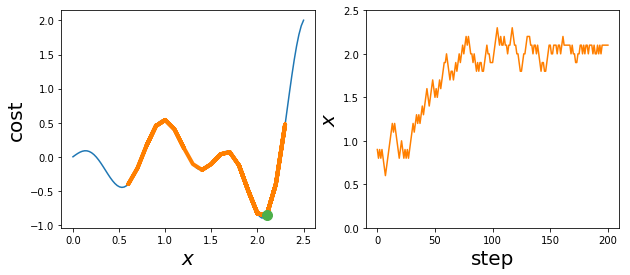

In [0]:
xt = 0.9    # 初期値
dx = 0.1   # 更新幅
tau = 200   # 最大更新回数

T = 10.0
r = (0.1/T) ** (1/tau)

x_history, cost_history = [xt], [cost(xt)]
for i in range(tau):
  T *= r
  xt = sa_update(T, cost, xt)
  x_history.append(xt)
  cost_history.append(cost(xt))
  
plot_cost_history(cost, x, x_history)
plt.show()

右図をみると過程の後半で温度が低くなっているのでだんだん$x$が収束(固まっている)様子がわかる。また山を超えることで最小解にたどり着くことができている。

このように温度(コストが上がる方向に確率的に状態が移る）ことによって山を乗り越え、最小値にたどり着くのがシミュレーテッドアニーリングである。

しかし、何度も繰り返し実行してみるとわかるが必ずしも最適解にたどり着くとは限らない。途中で確率的な過程が入っているので解が異なることがあるためである。また、シミュレーテッドアニーリングはコスト関数に関する情報をほとんど必要としない(状態更新のためにその近傍の情報だけでよい)。それにも関わらずSAは大域近似解を求めることができるアルゴリズムであるが、精度保証はない。このようにどのような最適化問題にも適用できるが精度保証がないアルゴリズムを[メタヒューリスティクス](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%BF%E3%83%92%E3%83%A5%E3%83%BC%E3%83%AA%E3%82%B9%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9)と呼ぶ。

このようにSAで確率的に状態が移り変わり変わっていく様子は、「温度揺らぎによって解を探す」と説明される。この「ゆらぎ」というのが確率的にコストが上がる方向に遷移することである。

後に紹介する量子アニーリングはSAからインスパイアされたアルゴリズムである。
「ゆらぎ」に温度ではなく、量子を使ったゆらぎ「量子ゆらぎ」を使って同じようなことが出来ないかという発想である。
しかし、状態(上記での変数$x$)が量子状態になるため、量子アニーリングの過程は上記で説明したSAの過程とは異なる。アルゴリズムのユーザーとしてはそこまで意識しなくても良いかもしれないが、知っているとアルゴリズムを動かす時のイメージや発展したアルゴリズム、古典シミュレーションを行うときに役に立つかと思う。また量子アニーリングもSAと同じくメタヒューリスティクスである。何でも解ける魔法ではないことに注意されたい。

量子アニーリングもシミュレーテッドアニーリングもメタヒューリスティクスではあるが計算時間$\tau$の極限$\tau \rightarrow \infty$において解が最適解に収束することが示されており、計算時間を伸ばすと解の平均的な精度はよくなる傾向にある。これらを使うときはどこで打ち切るかを計算コストと欲しい精度のちょうど良いバランスのところで調整する（量子アニーリングの場合はハードウェア制約で計算時間が決まってしまうが）。



### 組合せ最適化問題とSA

もう少しSAの話をさせてもらう。  
今後このチュートリアルで扱う問題のほとんどは「組合せ最適化問題」と呼ばれる問題である。上記で解いたのは連続変数$x$の問題であったが、組合せ最適化問題では$x$が離散変数の問題になる。  
離散変数になると問題を解くことが難しくなることが多い。

このように難しいときこそSAの出番だ。SAでは本当の最適解を厳密に解くことは諦めるが、出来るだけ高速に少しでも精度の良い解を求める。

組合せ最適化問題になったからといって上記のSAの話はなんら変わらない。
例えば3つの離散変数($x_1, x_2, x_3$)が2値($x_1, x_2, x_3 \in \{0,1\}$)の値を持つときにあるコスト$E(x_1, x_2, x_3)$が定義されて、コストを最小化する$x_1, x_2, x_3$それぞれの値を求めよという問題に変わる。

先ほどの連続変数のSAでは$x_t = x_t +dx$のように微小幅$dx$だけ動かしたが、離散変数なので$x_i = \tilde x_i$で0から1もしくが1から0に更新すればよい。

あとは同じ流れだ。では次から組合せ最適化問題に関連してイジングモデルを考えよう。